In [152]:
# Import Libraries

!pip install missingno

import pandas as pd
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandasql import sqldf

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [153]:
# Import the Data

df = pd.read_csv(r'Ecommerce.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [154]:
#  Let`s see what the data looks like with the describe() function
df.describe()

,Quantity,UnitPrice,CustomerID,Unnamed: 8
count,541909.000000,541909.000000,406829.000000,0.0
mean,9.552250,4.611114,15287.690570,NaN
std,218.081158,96.759853,1713.600303,NaN
min,-80995.000000,-11062.060000,12346.000000,NaN
25%,1.000000,1.250000,13953.000000,NaN
50%,3.000000,2.080000,15152.000000,NaN
75%,10.000000,4.130000,16791.000000,NaN
max,80995.000000,38970.000000,18287.000000,NaN


In [155]:
# Checking the missing values

miss_values = df.columns[df.isnull().any()]
print(f"Missing values:\n{df[miss_values].isnull().sum()}")

null_values = df.columns[df.isna().any()]
print(f"Null values:\n{df[null_values].isna().sum()}")

Missing values:
Description      1454
CustomerID     135080
Unnamed: 8     541909
dtype: int64
Null values:
Description      1454
CustomerID     135080
Unnamed: 8     541909
dtype: int64


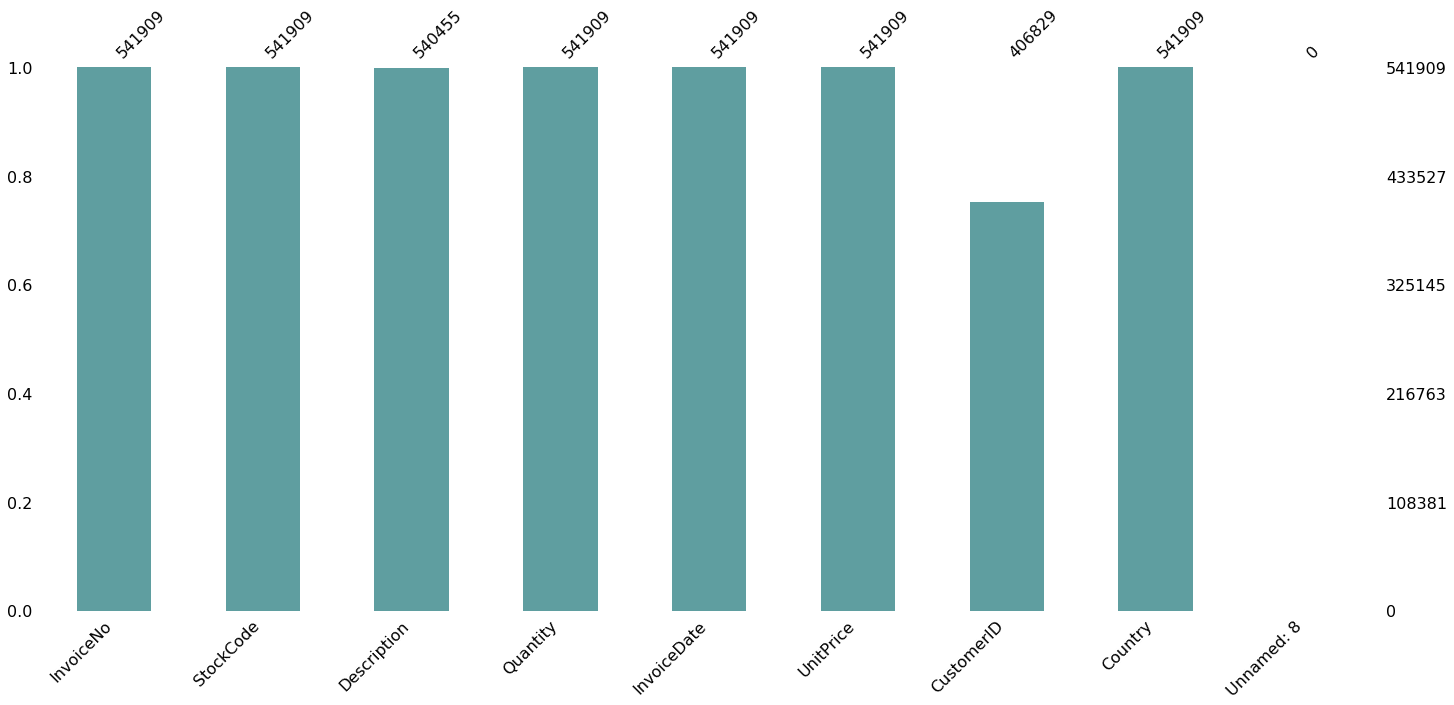

In [157]:
# Since there are missing values in the dataset, it will be a good idea to see, which columns are affected and will it be a problem for our analysis

null_plot = msno.bar(df, color = "#5F9EA0")

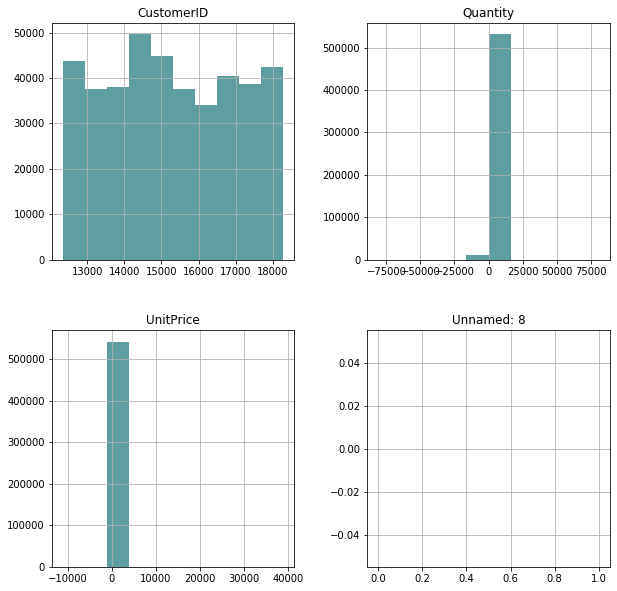

In [60]:
df_hist_plot = df.hist(figsize = (10,10), color = "#5F9EA0")

In [158]:
# We filter the table to see where the bulk of the NaN values are and their impact on the output.
# Clearly from the new table and the histogram the results are biased.

sales = sqldf("SELECT CustomerID, COUNTRY, COUNT(COUNTRY) AS Sales_Country, SUM(UNITPRICE) AS Total_Revenue, SUM(QUANTITY) AS Total_Items_Sold FROM df WHERE UNITPRICE >= '0' group by CustomerID;")
sales.head(10)

,CustomerID,Country,Sales_Country,Total_Revenue,Total_Items_Sold
0,NaN,United Kingdom,135078,1113108.13,269560
1,12346.0,United Kingdom,2,2.08,0
2,12347.0,Iceland,182,481.21,2458
3,12348.0,Finland,31,178.71,2341
4,12349.0,Italy,73,605.10,631
5,12350.0,Norway,17,65.30,197
6,12352.0,Norway,95,2211.10,470
7,12353.0,Bahrain,4,24.30,20
8,12354.0,Spain,58,261.22,530
9,12355.0,Bahrain,13,54.65,240


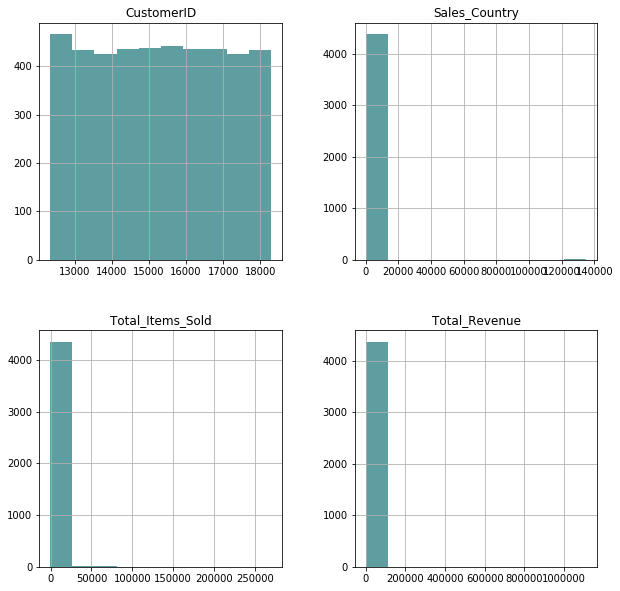

In [62]:
sales_hist_plot = sales.hist(figsize = (10,10), color = "#5F9EA0")

In [63]:
# Total revenue from NaN values makes a huge bias, that needs to be cleared.

top_sales = sqldf("SELECT * FROM sales order by Total_Items_Sold desc;")
top_sales.head(25)

,CustomerID,Country,Sales_Country,Total_Revenue,Total_Items_Sold
0,NaN,United Kingdom,135078,1113108.13,269560
1,14646.0,Netherlands,2085,5400.21,196719
2,12415.0,Australia,778,2499.82,77242
3,14911.0,EIRE,5903,31060.66,77180
4,17450.0,United Kingdom,351,3320.09,69029
5,18102.0,United Kingdom,433,5159.73,64122
6,17511.0,United Kingdom,1076,2607.08,63012
7,13694.0,United Kingdom,585,1163.81,61803
8,14298.0,United Kingdom,1640,2455.50,58021
9,14156.0,EIRE,1420,6544.29,57025


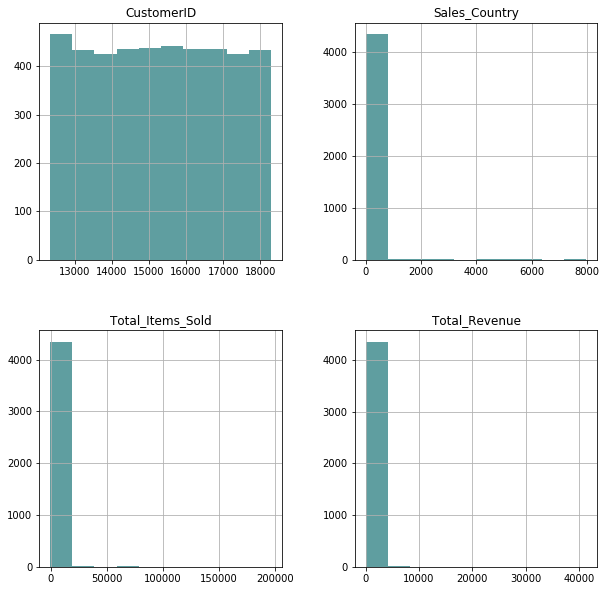

In [159]:
# After dropping NaN values, the values are more evenly spread now, apart from some outliers.

eliminated_na = top_sales.dropna()
eliminated_na.head()
eliminated_na_hist_plot = eliminated_na.hist(figsize = (10,10), color = "#5F9EA0")

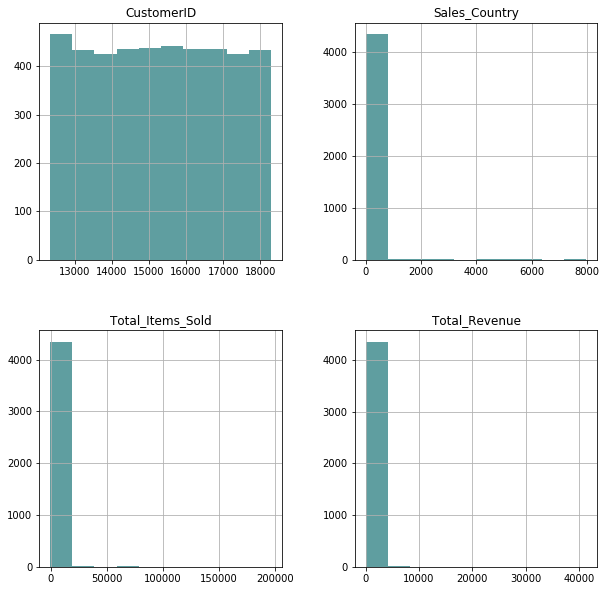

In [65]:
eliminated_na_hist_plot = eliminated_na.hist(figsize = (10,10), color = "#5F9EA0")

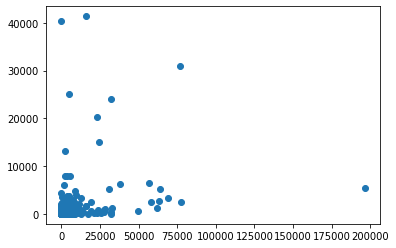

In [120]:
# Let`s see how the results will be clustering on a graph.

clustering = eliminated_na[["CustomerID", "Sales_Country", "Total_Revenue", "Total_Items_Sold"]]
clustering.head()
plt.scatter(clustering["Total_Items_Sold"], clustering["Total_Revenue"])

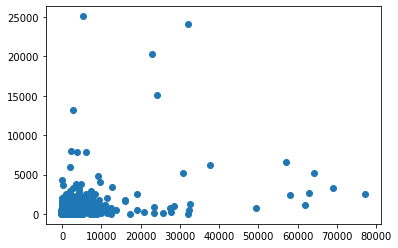

In [160]:
# The bulk of the values are stuck around the (0.0) point of the graph. To help with the better finds the cluster centers, we will set limitations to the top values of revenue and sales.

clustering = sqldf("SELECT * FROM clustering WHERE Total_Revenue < '30000' AND Total_Items_Sold < 100000;")
plt.scatter(clustering["Total_Items_Sold"], clustering["Total_Revenue"])

In [161]:
# We use Elbow method to find the best number of K - clusters.

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(clustering)
    Sum_of_squared_distances.append(km.inertia_)

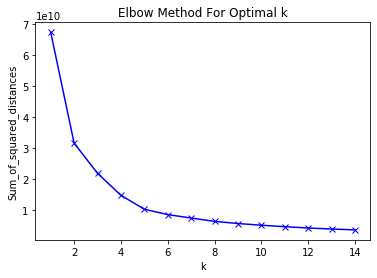

[[1.75492669e+04 4.90199336e+01 1.56773167e+02 3.63101883e+02]
 [1.45904241e+04 5.96089744e+01 1.83797918e+02 4.82134615e+02]
 [1.60798889e+04 6.37666667e+02 1.71065889e+03 3.05637778e+04]
 [1.49325000e+04 5.64500000e+02 2.90995500e+03 7.31355000e+04]
 [1.36070367e+04 2.47555102e+02 7.73573184e+02 2.90870612e+03]
 [1.47057674e+04 3.37720930e+02 1.11689837e+03 9.20976744e+03]
 [1.30869713e+04 4.97165605e+01 1.81156158e+02 4.72366242e+02]
 [1.57408333e+04 9.05833333e+02 3.10672333e+03 5.88955000e+04]
 [1.62220845e+04 4.09647887e+02 1.26293915e+03 5.14866197e+03]
 [1.69205000e+04 2.44964844e+02 6.67415977e+02 2.07644922e+03]
 [1.37626250e+04 3.64375000e+02 9.57571250e+02 1.94028750e+04]
 [1.55393333e+04 4.29966667e+03 1.98533067e+04 2.64076667e+04]
 [1.60290573e+04 5.43821656e+01 1.71904174e+02 3.92395966e+02]
 [1.26400000e+04 2.51000000e+02 1.91820550e+04 3.94300000e+03]]


In [123]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

print(km.cluster_centers_)

In [172]:
# We create an array with the columns with most weight to predict the clusters.

km = KMeans(n_clusters=6)
points = clustering[["Total_Items_Sold", "Total_Revenue"]].to_numpy()
y_km = km.fit_predict(points)
y_km

array([1, 1, 1, ..., 0, 0, 0])

Text(0.5, 1.0, 'Clustering the Customers')

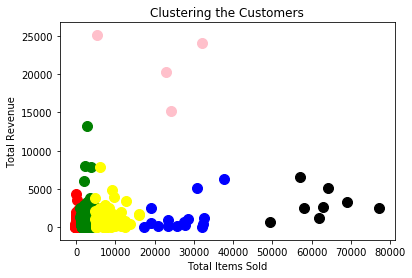

In [173]:
plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='green')
plt.scatter(points[y_km ==4,0], points[y_km == 4,1], s=100, c='yellow')
plt.scatter(points[y_km ==5,0], points[y_km == 5,1], s=100, c='pink')

plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')

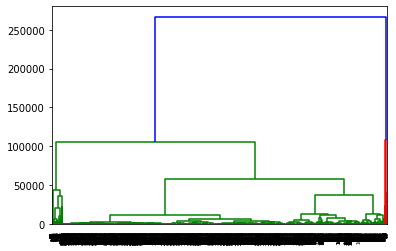

In [175]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(points, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=6, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(points)

Text(0.5, 1.0, 'Clustering the Customers')

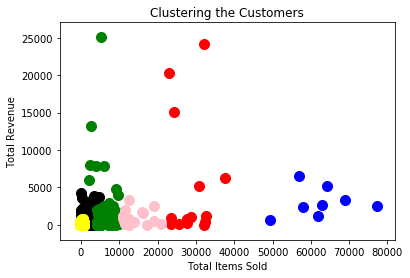

In [176]:
plt.scatter(points[y_hc ==0,0], points[y_hc == 0,1], s=100, c='red')
plt.scatter(points[y_hc==1,0], points[y_hc == 1,1], s=100, c='black')
plt.scatter(points[y_hc ==2,0], points[y_hc == 2,1], s=100, c='blue')
plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=100, c='green')
plt.scatter(points[y_hc ==4,0], points[y_hc == 4,1], s=100, c='yellow')
plt.scatter(points[y_hc ==5,0], points[y_hc == 5,1], s=100, c='pink')

plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')

In [177]:
clustering["cluster"] = km.labels_
clustering.head(25)

,CustomerID,Sales_Country,Total_Revenue,Total_Items_Sold,cluster
0,12415.0,778,2499.82,77242,1
1,17450.0,351,3320.09,69029,1
2,18102.0,433,5159.73,64122,1
3,17511.0,1076,2607.08,63012,1
4,13694.0,585,1163.81,61803,1
5,14298.0,1640,2455.50,58021,1
6,14156.0,1420,6544.29,57025,1
7,16684.0,281,709.93,49390,1
8,15311.0,2491,6267.75,37720,2
9,16422.0,399,1248.75,32592,2
